In [1]:
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00


In [2]:
import transformers
import datasets

## Load dataset

In [3]:
data = datasets.load_dataset("ktgiahieu/maccrobat2018_2020")
data = data['train'].train_test_split(test_size=0.1, seed=42)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 360
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 40
    })
})

In [5]:
data['train'][0].keys()

dict_keys(['tokens', 'tags'])

## Visualization

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import string

In [7]:
punctuations = set(string.punctuation)
def group(example):
    tags, tokens = [], []
    grp, current = None, None
    for tag, token in zip(example['tags'], example['tokens']):
        if tag == 'O': continue
        if tag.startswith('B-'):
            if current is not None:
                tags.append(current)
                tokens.append(' '.join(grp))

            grp = [token]
            current = tag.lstrip('B-')
        else:
            assert tag.startswith('I-')
            if token in punctuations: continue
            grp.append(token)

    return tags, tokens

TAGS, TOKENS = [], []
for example in data['train']:
    tags, tokens = group(example)
    TAGS.extend(tags)
    TOKENS.extend(tokens)

In [8]:
hello = []
for example in data['train']:
    tags = example['tags']
    hello.extend([t[2:] for t in tags])
Counter(hello)

Counter({'': 143265,
         'Age': 1709,
         'Sex': 330,
         'Duration': 1093,
         'Sign_symptom': 5808,
         'Diagnostic_procedure': 10420,
         'History': 2216,
         'Medication': 1839,
         'Dosage': 1323,
         'Activity': 145,
         'Detailed_description': 2984,
         'Quantitative_concept': 44,
         'Qualitative_concept': 38,
         'Disease_disorder': 2573,
         'Lab_value': 5744,
         'Date': 2684,
         'Clinical_event': 961,
         'Nonbiological_location': 951,
         'Biological_structure': 4516,
         'Family_history': 639,
         'Distance': 314,
         'Time': 164,
         'Mass': 4,
         'Personal_background': 119,
         'Coreference': 420,
         'Therapeutic_procedure': 1905,
         'Color': 30,
         'Texture': 38,
         'Administration': 97,
         'Volume': 172,
         'Shape': 39,
         'Subject': 91,
         'Area': 234,
         'Frequency': 169,
         'Outcome': 7

In [9]:
tags_dist = Counter(TAGS)
tokens_dist = Counter(TOKENS)

In [10]:
len(tags_dist)

41

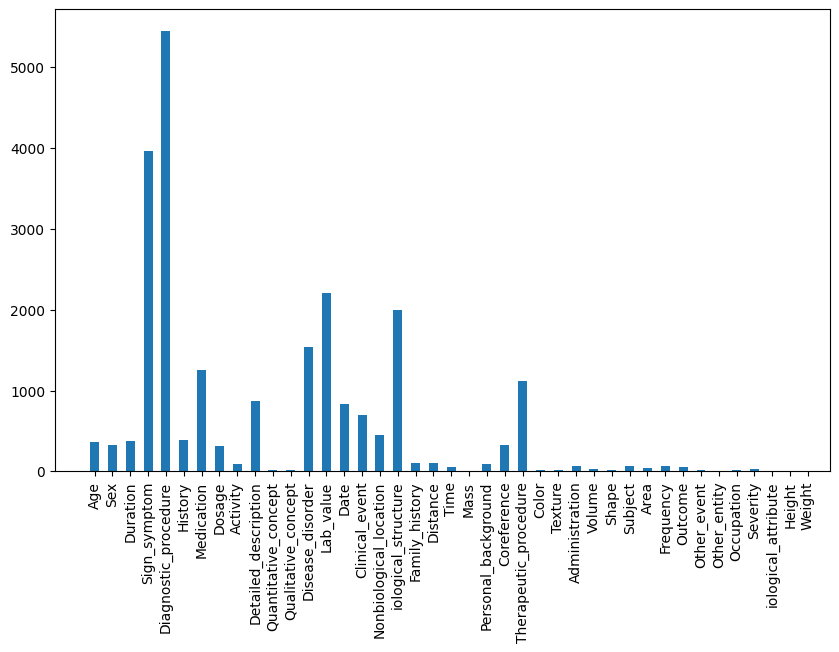

In [14]:
plt.figure(figsize=(10,6))
bins = np.arange(len(tags_dist)) - 0.5
plt.hist(TAGS, bins=bins, rwidth=0.5)
plt.xticks(rotation=90)
# plt.xticks([])
# plt.yticks([])
plt.savefig('entity-hist')

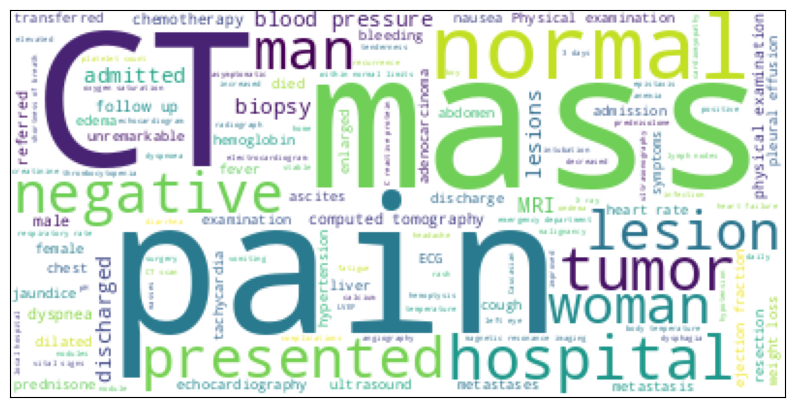

In [ ]:
wordcloud = WordCloud(
    background_color='white',
)
wordcloud.generate_from_frequencies(tokens_dist)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.xticks([])
plt.yticks([])
plt.savefig('token-wordcloud')

In [ ]:
def process(line):
    token, tag = line.split(',')
    token = token.split(':')[-1].strip()
    tag = tag.split(':')[-1].strip()

    return token, tag

with open('output.txt') as f:
    cur_token, cur_tag = None, None
    token_tag = []
    for line in f:
        line = line.strip()
        if not line: continue

        token, tag = process(line)
        if token.startswith('#'):
            cur_token += token.lstrip('#')
        else:
            if cur_token is not None:
                token_tag.append((cur_token, cur_tag))
            cur_token = token
            cur_tag = tag

    tokens, tags = [], []
    cur_tag, grp = None, []
    for token, tag in token_tag:
        if tag == 'O': continue
        if tag.startswith('B-'):
            if cur_tag is not None:
                tags.append(cur_tag)
                tokens.append(' '.join(grp))

            grp = [token]
            cur_tag = tag.lstrip('B-')
        else:
            assert tag.startswith('I-')
            if token in punctuations: continue
            grp.append(token)


tokens, tags

(['63 year old',
  'woman',
  'no known cardiac history',
  'presented',
  'dyspnea',
  'intubation',
  'ventilatory support',
  'hospital',
  'discomfort',
  'palpitations',
  'syncope',
  'infection',
  'afebrile',
  'normotensive',
  'tachycardia'],
 ['Age',
  'Sex',
  'History',
  'Clinical_event',
  'Sign_symptom',
  'Therapeutic_procedure',
  'Therapeutic_procedure',
  'Nonbiological_location',
  'Sign_symptom',
  'Sign_symptom',
  'Sign_symptom',
  'Sign_symptom',
  'Sign_symptom',
  'Sign_symptom',
  'Sign_symptom'])

## Preprocessing

In [ ]:
label_list = ['B-Activity', 'B-Administration', 'B-Age', 'B-Area', 'B-Biological_attribute', 'B-Biological_structure', 'B-Clinical_event', 'B-Color', 'B-Coreference', 'B-Date', 'B-Detailed_description', 'B-Diagnostic_procedure', 'B-Disease_disorder', 'B-Distance', 'B-Dosage', 'B-Duration', 'B-Family_history', 'B-Frequency', 'B-Height', 'B-History', 'B-Lab_value', 'B-Mass', 'B-Medication', 'B-Nonbiological_location', 'B-Occupation', 'B-Other_entity', 'B-Other_event', 'B-Outcome', 'B-Personal_background', 'B-Qualitative_concept', 'B-Quantitative_concept', 'B-Severity', 'B-Sex', 'B-Shape', 'B-Sign_symptom', 'B-Subject', 'B-Texture', 'B-Therapeutic_procedure', 'B-Time', 'B-Volume', 'B-Weight', 'I-Activity', 'I-Administration', 'I-Age', 'I-Area', 'I-Biological_attribute', 'I-Biological_structure', 'I-Clinical_event', 'I-Color', 'I-Coreference', 'I-Date', 'I-Detailed_description', 'I-Diagnostic_procedure', 'I-Disease_disorder', 'I-Distance', 'I-Dosage', 'I-Duration', 'I-Family_history', 'I-Frequency', 'I-Height', 'I-History', 'I-Lab_value', 'I-Mass', 'I-Medication', 'I-Nonbiological_location', 'I-Occupation', 'I-Other_entity', 'I-Other_event', 'I-Outcome', 'I-Personal_background', 'I-Qualitative_concept', 'I-Quantitative_concept', 'I-Severity', 'I-Shape', 'I-Sign_symptom', 'I-Subject', 'I-Texture', 'I-Therapeutic_procedure', 'I-Time', 'I-Volume', 'I-Weight', 'O']
label = datasets.ClassLabel(names=label_list)
data = data.map(lambda x: {
    "tokens": x['tokens'],
    "tags": x["tags"],
    "numeric_tags": [
        label.encode_example(t)
        for t in x["tags"]
    ],
})

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags', 'numeric_tags'],
        num_rows: 360
    })
    test: Dataset({
        features: ['tokens', 'tags', 'numeric_tags'],
        num_rows: 40
    })
})

In [ ]:
task = "ner"
model_checkpoint = "ktgiahieu/RoBERTa-large-PM-M3-Voc-hf-finetuned-ner"
batch_size = 16

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/812k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/472k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

In [ ]:
tokenizer("Hello, this is one sentence!")

{'input_ids': [0, 427, 24017, 15, 491, 345, 818, 17812, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

{'input_ids': [0, 427, 24017, 3267, 491, 345, 818, 17812, 9490, 860, 6786, 2245, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
example = data["train"][7]
print(example["tokens"])

['An', '8', '-', 'year', '-', 'old', 'boy', 'with', 'S549R/1717', '-', '1', 'G', '\u2009', '>', '\u2009', 'A', 'genotype', 'was', 'started', 'on', 'ivacaftor', '(', '150', 'mg', 'b.i.d', '.', ')', 'on', 'compassionate', 'use', '.', '\n', 'At', 'the', 'age', 'of', '9', 'months', 'he', 'was', 'diagnosed', 'with', 'CF', 'due', 'to', 'failure', 'to', 'thrive', '.', '\n', 'His', 'previous', 'history', 'was', 'remarkable', 'for', 'recurring', 'nasal', 'polyposis', 'requiring', 'endoscopic', 'surgery', 'and', 'exocrine', 'pancreatic', 'insufficiency', 'necessitating', 'enzyme', 'replacement', 'therapy', '.', '\n', 'He', 'grew', 'with', 'body', 'weight', 'and', 'height', 'along', 'the', '10th', 'percentile', '.', '\n', 'He', 'suffered', 'from', 'rather', 'mild', 'respiratory', 'symptoms', ',', 'primarily', 'intermittent', 'productive', 'cough', ',', 'and', 'had', 'close', 'to', 'normal', 'lung', 'function', 'parameters', 'in', 'previous', 'years', 'as', 'measured', 'by', 'body', 'plethysmograp

In [ ]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['<s>', 'ĠAn', 'Ġ8', 'Ġ-', 'Ġyear', 'Ġ-', 'Ġold', 'Ġboy', 'Ġwith', 'ĠS', '549', 'R', '/', '17', '17', 'Ġ-', 'Ġ1', 'ĠG', 'Ġ', 'âĢī', 'Ġ>', 'Ġ', 'âĢī', 'ĠA', 'Ġgenotype', 'Ġwas', 'Ġstarted', 'Ġon', 'Ġ', 'ivac', 'aft', 'or', 'Ġ(', 'Ġ150', 'Ġmg', 'Ġb', '.', 'i', '.', 'd', 'Ġ.', 'Ġ)', 'Ġon', 'Ġcompassion', 'ate', 'Ġuse', 'Ġ.', 'Ġ', 'Ċ', 'ĠAt', 'Ġthe', 'Ġage', 'Ġof', 'Ġ9', 'Ġmonths', 'Ġhe', 'Ġwas', 'Ġdiagnosed', 'Ġwith', 'ĠCF', 'Ġdue', 'Ġto', 'Ġfailure', 'Ġto', 'Ġthrive', 'Ġ.', 'Ġ', 'Ċ', 'ĠHis', 'Ġprevious', 'Ġhistory', 'Ġwas', 'Ġremarkable', 'Ġfor', 'Ġrecurring', 'Ġnasal', 'Ġpolyposis', 'Ġrequiring', 'Ġendoscopic', 'Ġsurgery', 'Ġand', 'Ġexocrine', 'Ġpancreatic', 'Ġinsufficiency', 'Ġnecessitating', 'Ġenzyme', 'Ġreplacement', 'Ġtherapy', 'Ġ.', 'Ġ', 'Ċ', 'ĠHe', 'Ġgrew', 'Ġwith', 'Ġbody', 'Ġweight', 'Ġand', 'Ġheight', 'Ġalong', 'Ġthe', 'Ġ10', 'th', 'Ġpercentile', 'Ġ.', 'Ġ', 'Ċ', 'ĠHe', 'Ġsuffered', 'Ġfrom', 'Ġrather', 'Ġmild', 'Ġrespiratory', 'Ġsymptoms', 'Ġ,', 'Ġprimarily', 'Ġintermittent', 'Ġ

In [ ]:
len(example[f"numeric_tags"]), len(tokens)

(302, 380)

In [ ]:
print(tokenized_input.word_ids())

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 9, 10, 11, 12, 12, 13, 14, 14, 15, 16, 17, 18, 19, 20, 20, 20, 20, 21, 22, 23, 24, 24, 24, 24, 24, 25, 26, 27, 28, 28, 29, 30, 31, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 81, 82, 83, 84, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 122, 123, 124, 124, 124, 124, 125, 126, 127, 127, 128, 128, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 140, 141, 142, 143, 144, 145, 145, 145, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 166, 167, 168, 168, 169, 170, 171, 171, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 187, 188, 189

In [ ]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"numeric_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

380 380


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True, max_length=512
    )

    labels = []
    for i, label in enumerate(examples[f"numeric_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if j is None else label[j] for j in word_ids]
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = data.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]